## Writeup Template
### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt

In [3]:
import writeup
import features

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the file **`features.py`** lines 20-33. This step has been cached through the **`joblib.Memory.cache`** decorator embedded in **`scikit-learn`** in order to speed up the training.

In the file **`training.py`**, I wrote a function (lines 17-29) for reading the vehicles and non-vehicles images and for assigning to each of them the correct class label. Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

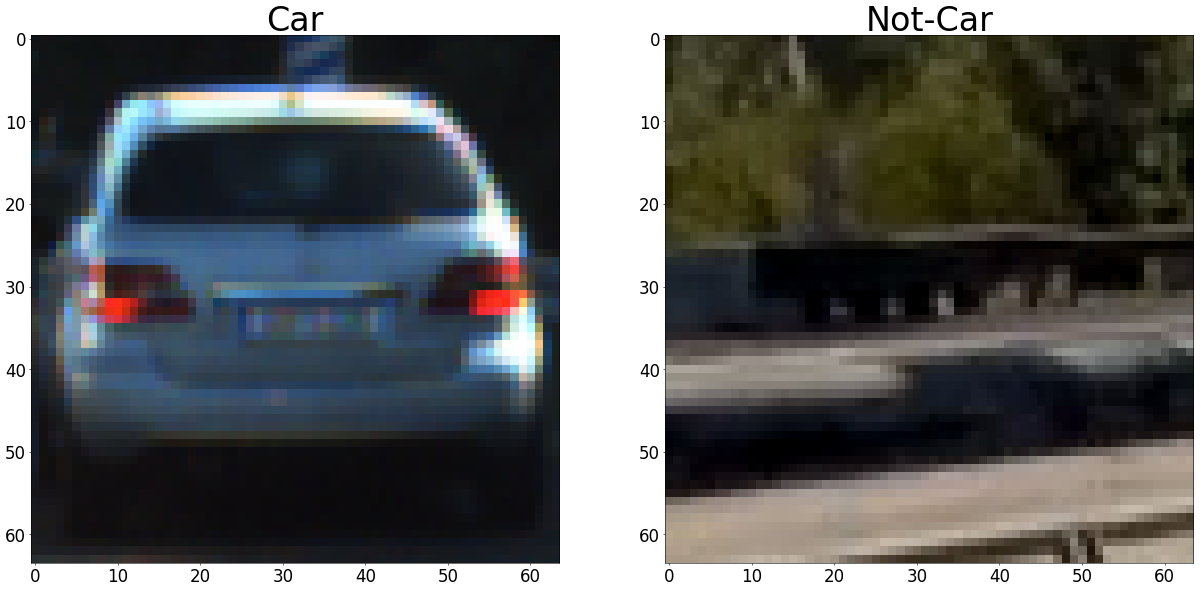

In [4]:
np.random.seed(8888)
vehicle = writeup.get_random_image('vehicles/*/*')
non_vehicle = writeup.get_random_image('non-vehicles/*/*')
plt.subplot(121); plt.imshow(vehicle[..., ::-1]); plt.title("Car", fontsize=48)
plt.subplot(122); plt.imshow(non_vehicle[..., ::-1]); plt.title("Not-Car", fontsize=48);

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here are some examples using the `RGB`, `HLS` and `YUV` color spaces and as HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

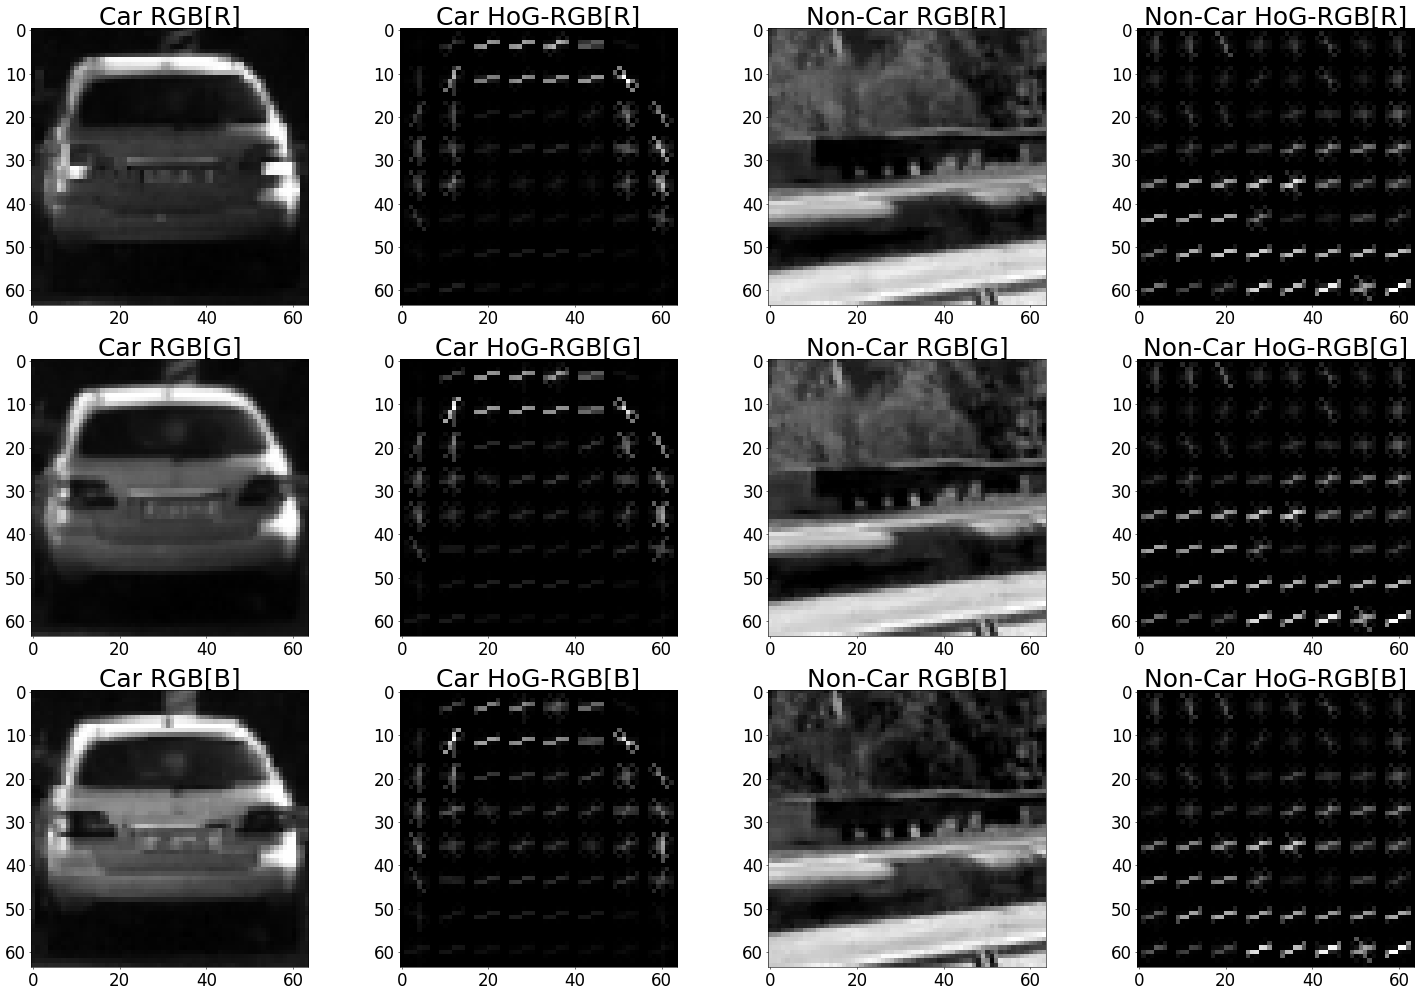

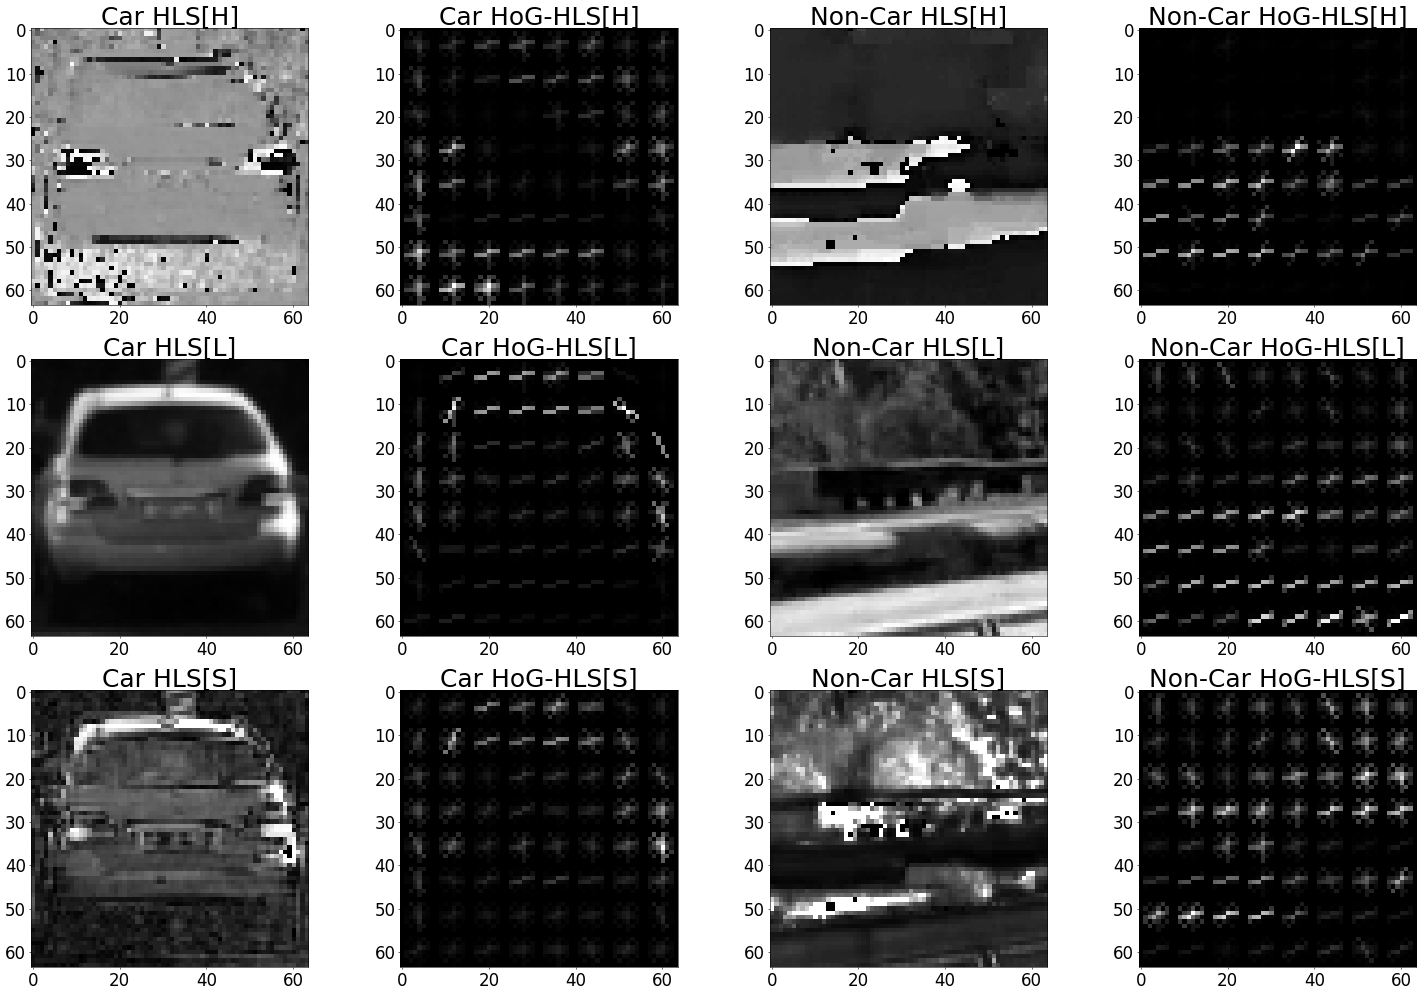

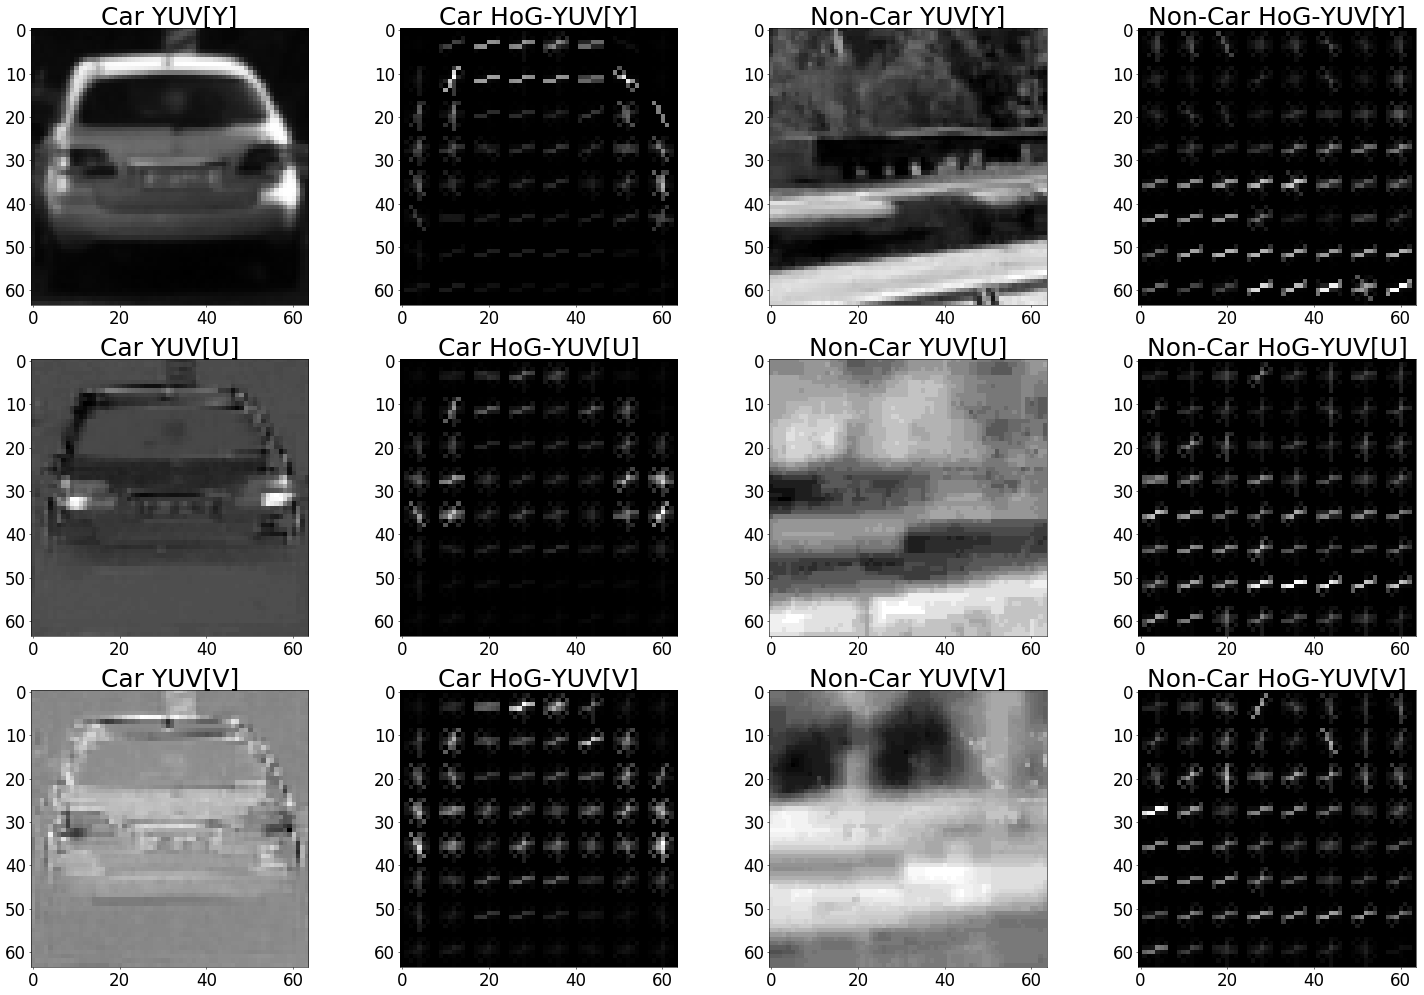

In [5]:
writeup.plot_hogs(vehicle, non_vehicle)

#### 2. Explain how you settled on your final choice of HOG parameters.

In the previous examples I could detect clearly distinct patterns in vehicles and non-vehicles almost independently from the color space: non-vehicles exhibits more uniform and random gradient distribution than vehicles. Nevertheless, it becomes most evident in luminance channels like YUV[Y] and HLS[L].

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using as input the concatation of the following features (file **`features.py`** lines 98-133):
 1. HoG from one or more channels
 2. Color channels downsampled to 32x32
 3. Color histogram with 32 bins

I chose a linear kernel because the RBF (the default) seemed much slower at prediction time with barely noticeable improvements, hence I think it is not well suited for a video streaming application.

In order to tune the hyper-parameters I ran a cross validation using a grid search approach (file **`training.py`** lines 46-49. Here is the set of parameters I tried in any combination:
 1. Color space: RGB, HLS, LUV
 2. The color channel to extract the HoG: 1, 2, 3, all

I pre-tuned the SVM C parameter on a smaller dataset to reduce the search space.

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I implemented the sliding window search along the lines of the function `find_cars` shown in the lectures. For the sake of clearness and maintanibility I split it up in:
 1. `generate_windows` (file **`features.py`** lines 53-90): a generator function yielding the correct slices to extract from the HoG unflattened data, from the resampled image and the actual position (i.e. bounding box) in the original image.
 2. `adjust_scale` (file **`features.py`** lines 92-96): it simply resample the image to fit the desired scale (i.e. zoom) factor.
 3. `extract_features` (file **`features.py`** lines 98-133): it calculates once for all the HoG features on the whole image; it then iterates over the windows to extract, flattens and concatenates the color, histogram and HoG features of each one.

In order to chose the scales and overlap values to use I performed some tests on the test images.
For each combination of scale/overlap I manually counted how many cars had been more or less detected (true positive). I used fractional values to take into account partial but still valuable detections. I also counted the number of false positive (actually, in this case too, I assigned fractional values to quiestionable errors like cars in the other roadway). I used this values to calculate the precision $\left( TP \over {TP+FP} \right)$ and recall power $\left( TP \over {TP+FN} \right)$ of each combination (see [wiki](https://en.wikipedia.org/wiki/Precision_and_recall)).

Here is a summary of such analysis:

| Overlap | Scale ||  Recall  | Precision |
|---------|-------||----------|-----------|
|      0% |     2 ||      22% |       50% |
|      0% |   1.5 ||      22% |       33% |
|      0% |     1 ||      72% |   **76%** |
|      0% |   0.5 ||      13% |       19% |
|         |       ||          |           |
|     50% |     2 ||      83% |   **60%** |
|     50% |   1.5 || **100%** |       56% |
|     50% |     1 || **100%** |   **60%** |
|     50% |   0.5 ||      48% |       42% |
|         |       ||          |           |
|     75% |     2 ||      89% |       50% |
|     75% |   1.5 || **100%** |       40% |
|     75% |     1 || **100%** |       40% |
|     75% |   0.5 ||      83% |       42% |

I then chose to use scale 1 with 50% of overlap, because it seemed to have very high recall with a top-three precision. But tests on static images and on the project video showed that, in some cases, the number of windows detecting it was not enough to discriminate it from false alarms. I then tried to increase the overlap, but I was still unsatisfied when the car was too far. I eventually chose an overlap of 25% and to add the scale 0.5 in a quite narrow band (for speed considerations).

In the following figure you can see in blue the sliding windows I ended up to search for. For sake of clearness, I have also shown in red the windows of the same size **without** overlap.

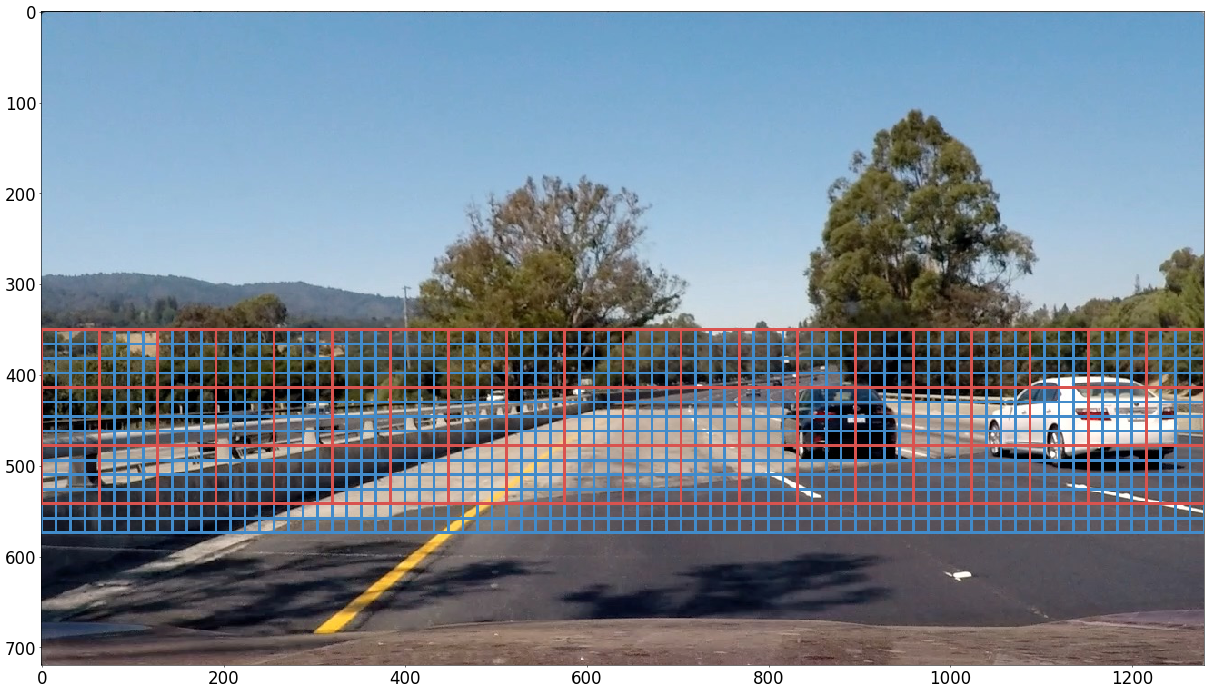

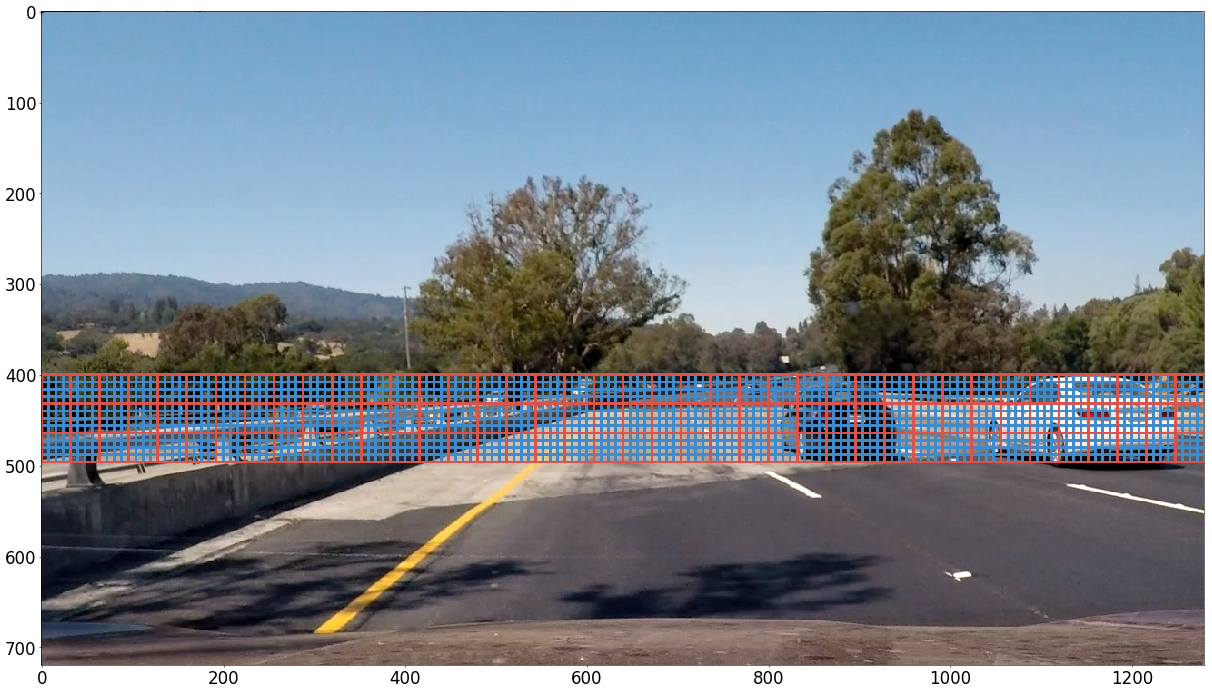

In [6]:
test_image = writeup.get_random_image('test_images/*')
writeup.plot_windows(test_image, scale=1)
writeup.plot_windows(test_image, scale=0.5)

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on a single scale using HLS 3-channel HOG features plus spatially binned color and histograms of color in the feature vector.

Here are some example images: on the left, the windows that were classified as "car" by the SVM (blue=scale 0.5, green=scale 1); on the right, the merged boxes (see below for how boxes have been merged and for the meaning of the number).

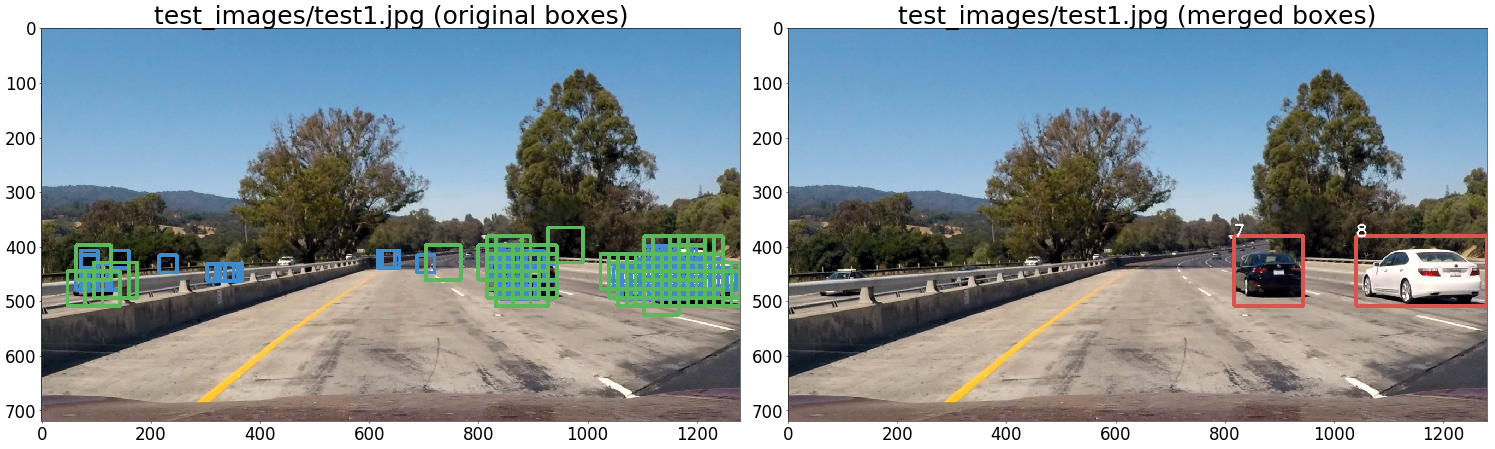

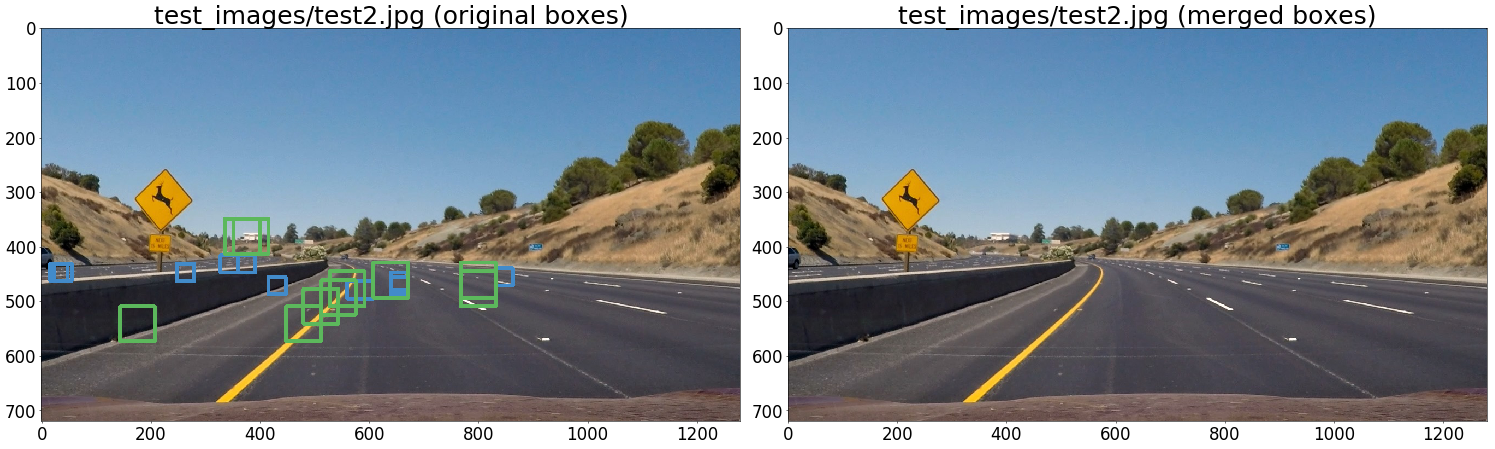

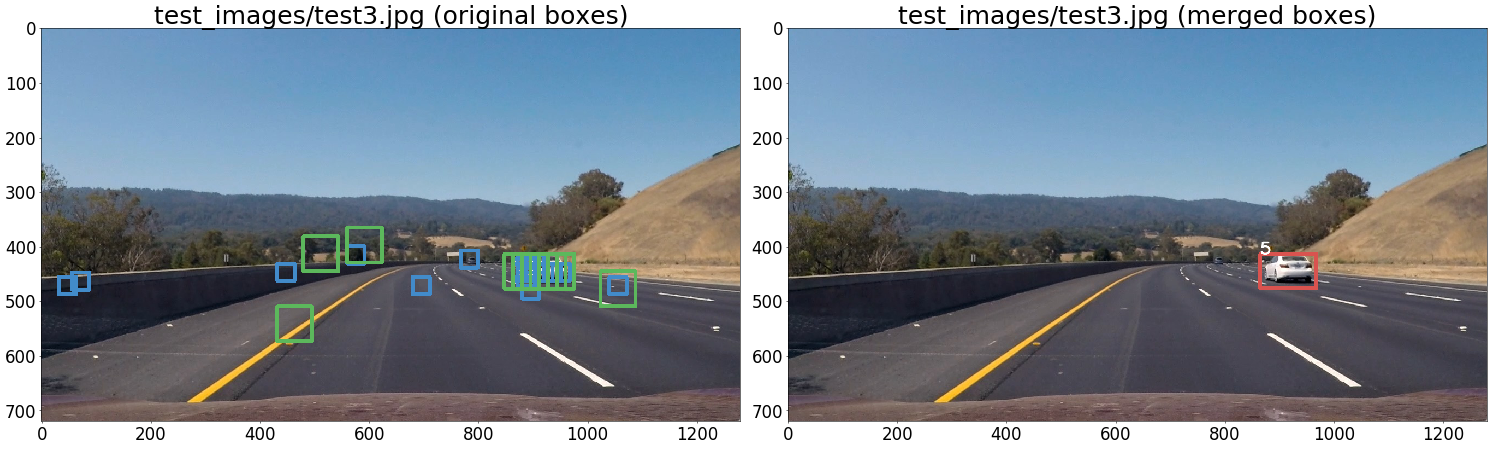

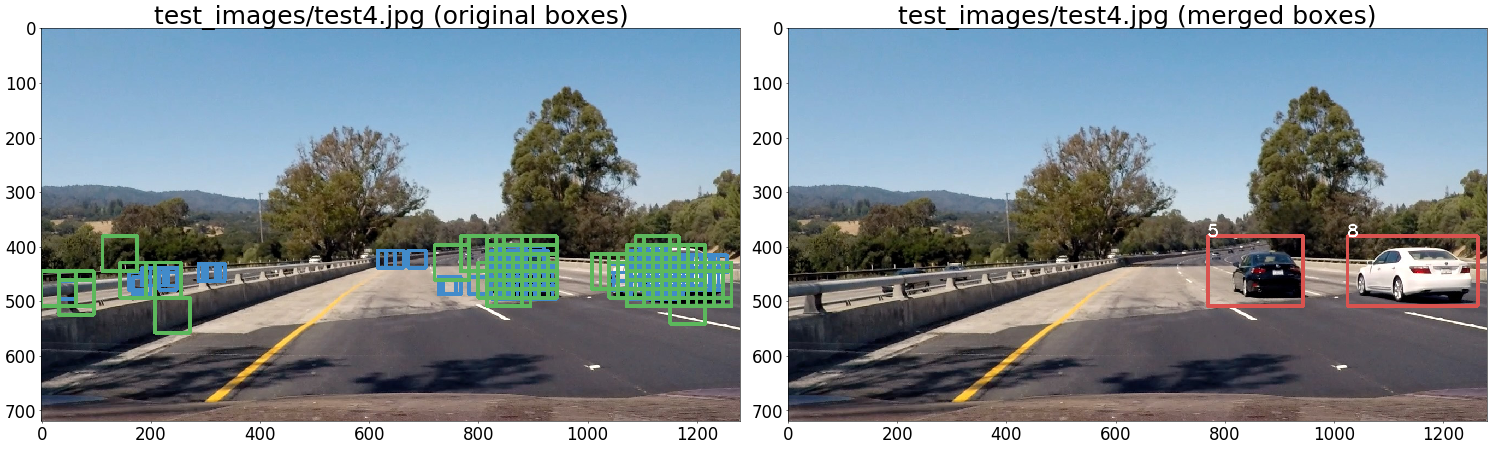

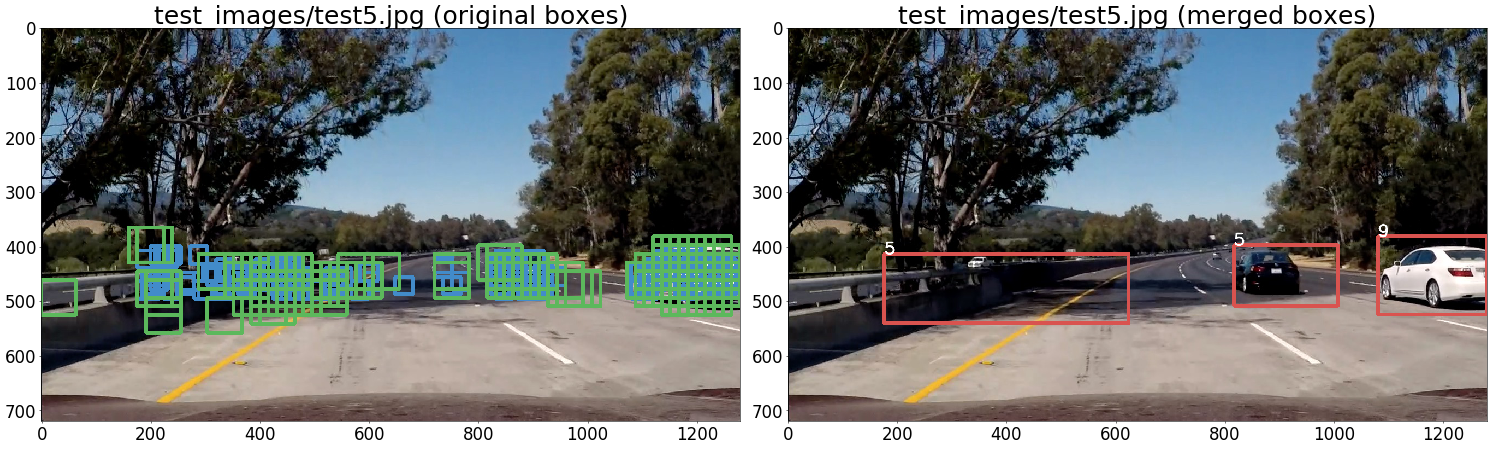

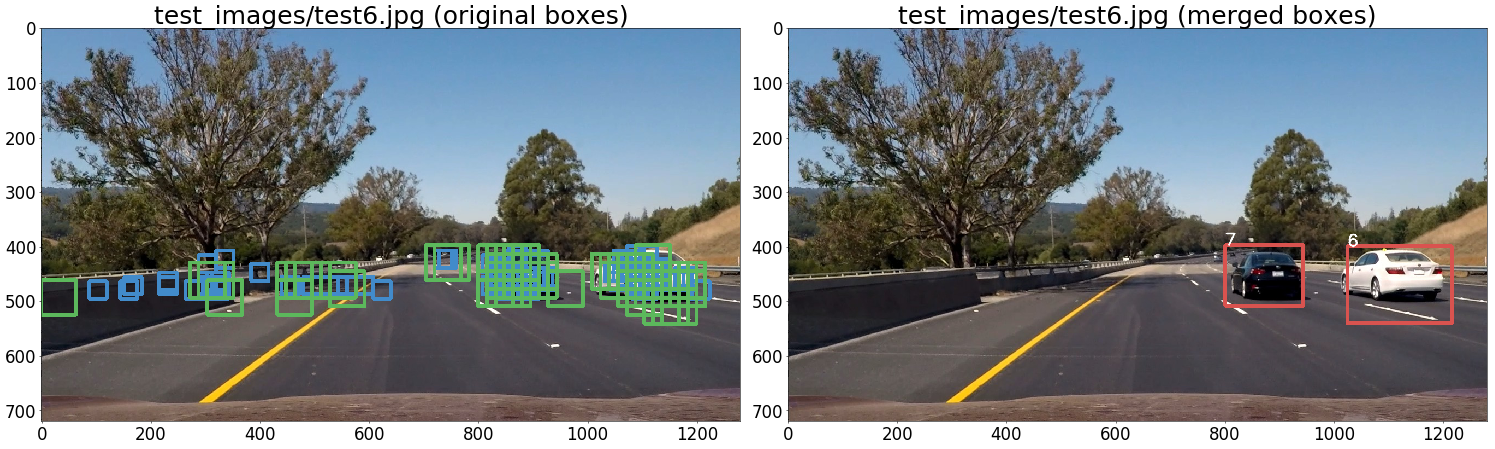

In [7]:
for path in sorted(glob.glob('test_images/*'))[:6]:
    writeup.plot_result(path, use_heatmap=False)

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video_output.mp4). For the parameters used to generate it see **`model.py`** lines 8-14.

<video controls src="project_video_output.mp4" width="100%"/>

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

In order to make the result nicer and more useful I merged the found boxes in this way (file **`tracking.py`**):
 1. I built a heatmap counting, for each pixel, how many boxes fell over it (lines 24-32)
 2. I applied a first threshold clamping to zero every pixel below it (line 71); this is important because it allows separating near blobs
 3. I discarded the connected non-zero region whose median value fell below a second threshold (73-82); the median helps to filter false positives, which tend to be scattered, and provides some robustness to outliers.

Moreover, during the video, I exploited the boxes gathered in the previous frames to build the heatmaps (like a FIR filter, lines 119-120), in order to make the detection more robust and smoother. To see how this helped, compare the detection in the static frame `./test_images/test5.jpg` shown in the previous section, point 2, with `./project_video_output.mp4`. In the static detection the tree shadow is taken as car, while in the video such detection is filtered out.

Here are some example results showing: on the right the frame with overlaid the boxes found (taking into account the *history*) and the final result (red box with a number indicating the average heat); on the right the corresponding heatmap.

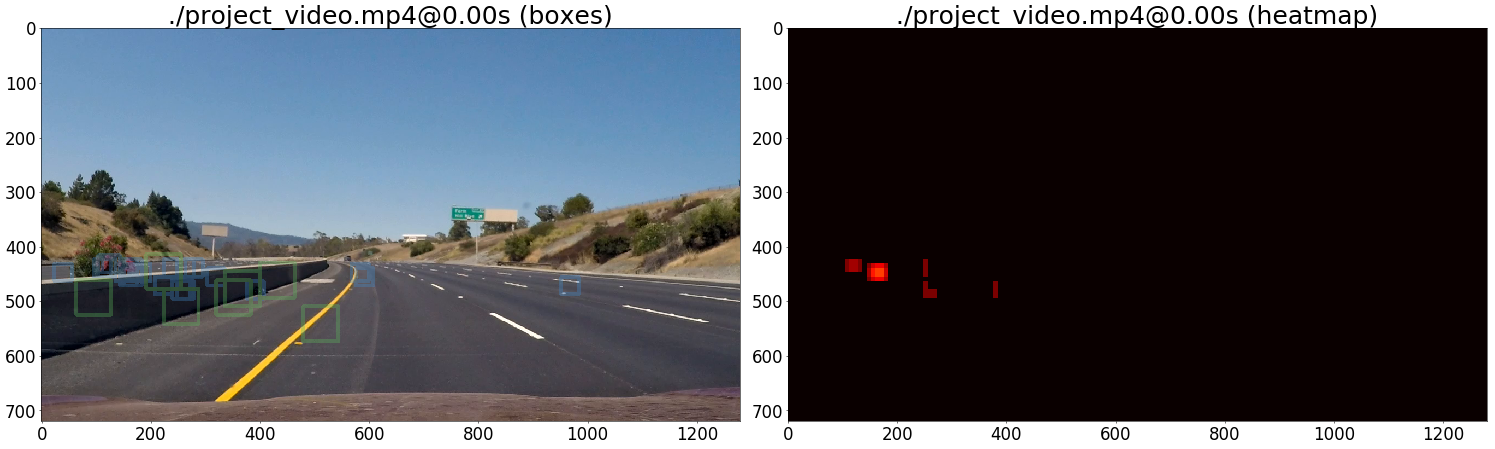

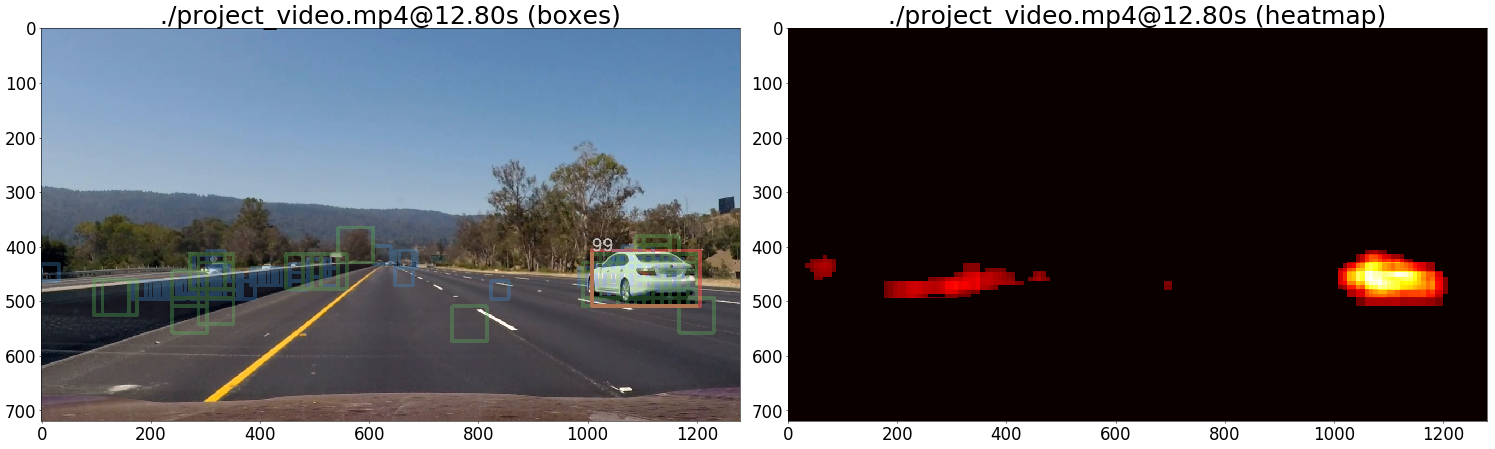

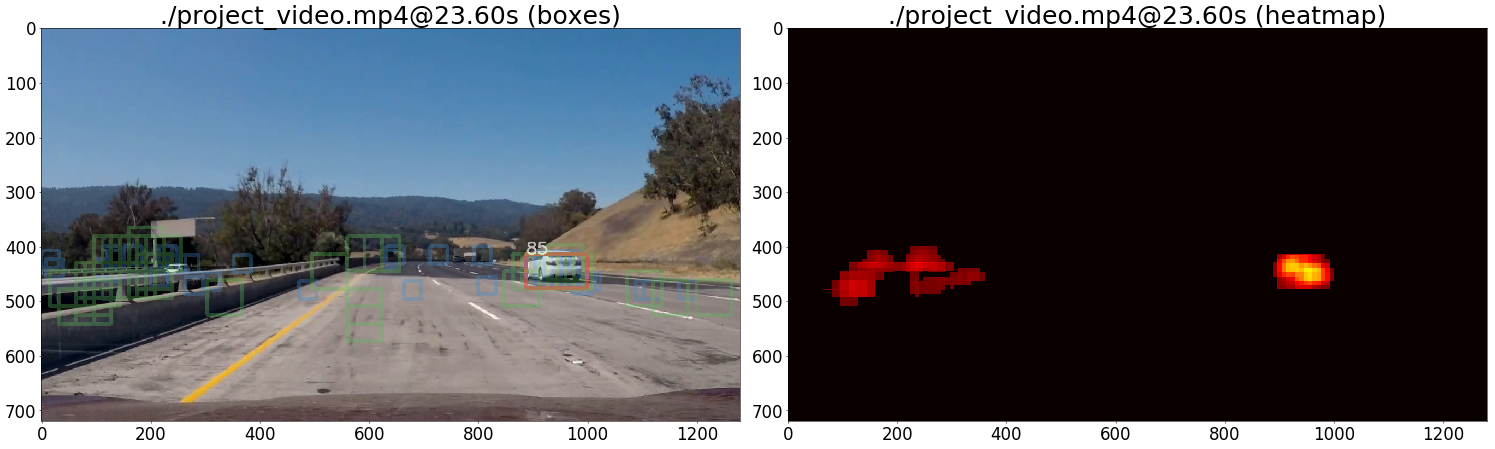

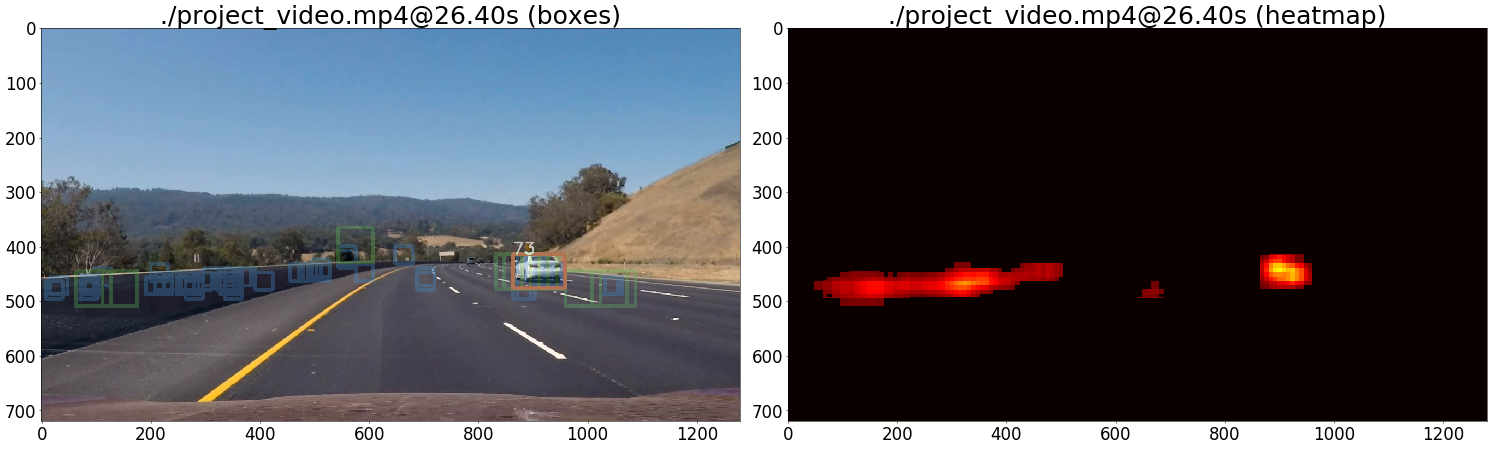

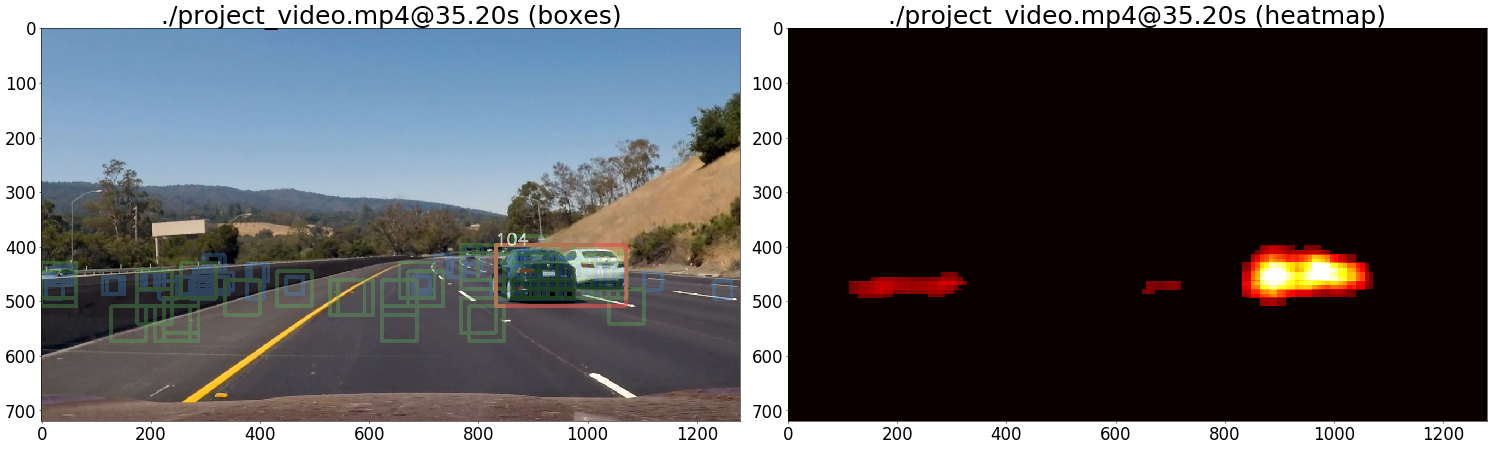

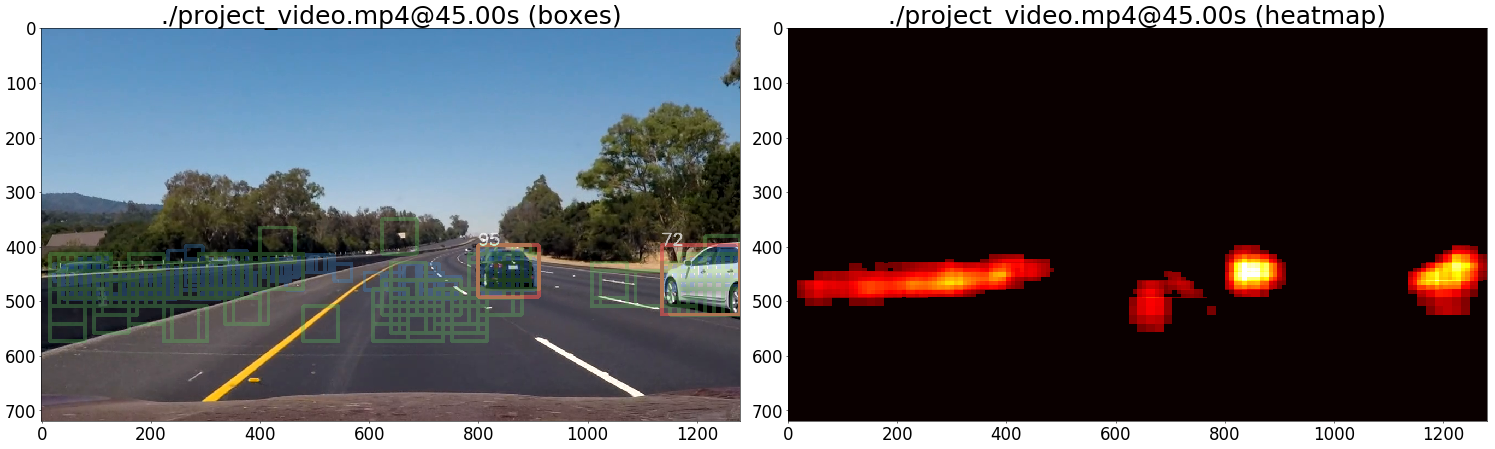

In [8]:
n = 6
for s in np.linspace(3, 47, n) + np.random.randint(-3, 4, n): #[10, 29, 37] [23.6, 29.4, 48] [13+0.04*13, 28] [3, 8.8, 22.6, 31.4, 37.2, 45]
    writeup.plot_frames('./project_video.mp4', s, 1, prerun=True, use_heatmap=True)

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The main issue I faced with this project, and that I have not yet fully solved, is the processing time. On my *Intel(R) Core(TM) i7-4500U CPU @ 1.80GHz* I barely go under 3 seconds per frame. This is dispite my efforts like:
 1. Using `sklearn.svm.LinearSVC` instead of `sklearn.svm.SVC`
 2. Tuning the SVM C parameter in order to reduce overfitting, but also memory footprint (less support vectors to memorize) and hence less prediction time
 3. Calling `skimage.feature.hog` only once for each frame and scale (as explained in the lectures)
 4. Reducing the search area and the overlap between windows without sacrifying the outcome

A second issue was the threshold: calibrating them was painful, also because maybe some *normalization* w.r.t. FIR length would have been useful. Moreover, increasing the first threshold increases the median value of regions, therefore the threshold are not independent and need to be calibrated simultaneously.

A limitation of the approach is that, because of the FIR length, vehicles are not recognized as they enter the scene. Anyway, in the current implementation, the lenght is fixed to 12 frames, which correspond to approximately half second, which is pretty comparable with human reaction time.

I see room for improvement in:
 1. Classification: the classifier still have too many false positives, which I worked hard to reduce through the video averaging, but, in my opinion, they should not be there in first place.
 2. Separation: vehicles are detected but not taken apart (close cars share the same box until they separate).
 3. Tracking: I think it would be useful to track each detected vehicle from frame to frame, so that one could calculate e.g. speed and route of them.